## Load and explore Purkinje locomotion data set

In [29]:
import h5py
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [30]:
def Load_Dict_from_HDF5(filename, attrs=False):
    # Modified from: https://codereview.stackexchange.com/questions/120802
    # attrs: (Default False) If True, the routine will also load the attributes of each object.
    #        If "Root", it will only load the attributes of the first file node.

    def recursively_load_dict_contents_from_group(h5file, path, attrs):
        ans = {}
        if len(ans) == 0 and not attrs is False:
            ans["Root Attrs"] = {key:(elem if not isinstance(elem, h5py._hl.base.Empty) else []) for key, elem in dict(h5file['/'].attrs).items()}
            if "oo" in attrs: attrs = False
        for key, item in h5file[path].items():
            if isinstance(item, h5py._hl.dataset.Dataset):
                ans[key] = item[()]
                if attrs: ans["%s_Attrs" % key] = dict(item.attrs)
            elif isinstance(item, h5py._hl.base.Empty):
                ans[key] = []
            elif isinstance(item, h5py._hl.group.Group):
                ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/', attrs)
                if attrs: ans[key]["Attrs"] = dict(item.attrs)
        return ans

    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/', attrs)


In [31]:
#filename='../data/EncDec_NLT_AddT_spth0-0.h5'
filename='../data/EncDec_NLT_AddT_spth0d05-0d5.h5'
data = Load_Dict_from_HDF5(filename)

In [32]:
data.keys()

dict_keys(['Locomotion Reference', 'Pseudo-Predictions'])

In [33]:
data['Pseudo-Predictions'].keys()

dict_keys(['Cell Names', 'Identifier', 'Legend matrix', 'Matrix'])

In [34]:
data['Pseudo-Predictions']['Legend matrix']

b"Axis 0: Datapoints\nAxis 1: variables of the pseudo-predictions (0-3: limbs FR-HR-FL-HL terms respectively, 4: nonlinear limb term, 5: sum of all other terms)\nAxis 2: Neurons (lookup table of identity in 'Cell Names')"

4 linear, 1 nonlinear and 1 nuisance component. All components together are the original firing rate of each neuron. We will use the sum of the 1st 5 (i.e. linear and nonliear) components, that is without the nuisance component.

In [35]:
data['Pseudo-Predictions']['Matrix'].shape # time points x features x neurons

(1816281, 6, 105)

In [8]:
data['Locomotion Reference'].keys()

dict_keys(['4D-phase Trig. Decomp.', 'Acq. Freq.', 'Cross-validated Pseudo-dominance outputs', 'Global Phase 4D distance', 'Global Phase PCA embeddings', 'Original Sessions of Behavioral Reference', 'PCA selected embeddings and rotation sense', 'PCA-phase Trig. Decomp.', 'Phaser-phase Trig. Decomp.', 'Phases', 'Wheel Speed', 'X-accel Matrix', 'X-pos Matrix', 'X-speed Matrix', 'Y-accel Matrix', 'Y-pos Matrix', 'Y-speed Matrix', 'Z-accel Matrix', 'Z-pos Matrix', 'Z-speed Matrix'])

In [11]:
data['Locomotion Reference']['Y-pos Matrix'].shape # time points x #limbs

(1816281, 4)

In [12]:
data['Locomotion Reference']['Wheel Speed'].shape # time points x #limbs

(1816281,)

Front right limb movement (x-axis) :

Text(0, 0.5, 'Front right limb position')

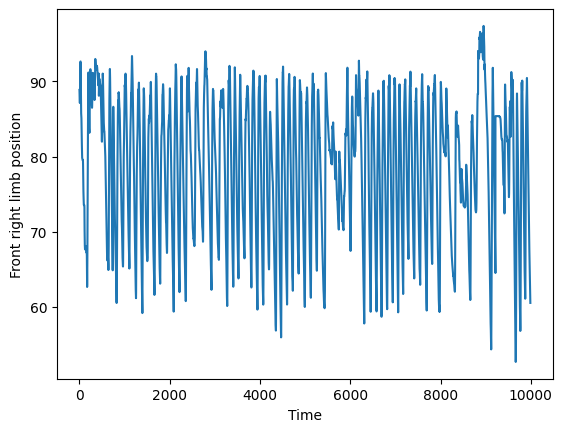

In [46]:
plt.plot(data['Locomotion Reference']['Pos. X Matrix'][10:10000,0])
plt.xlabel('Time')
plt.ylabel('Front right limb position')

Text(0, 0.5, 'Firing rate 1st neuron')

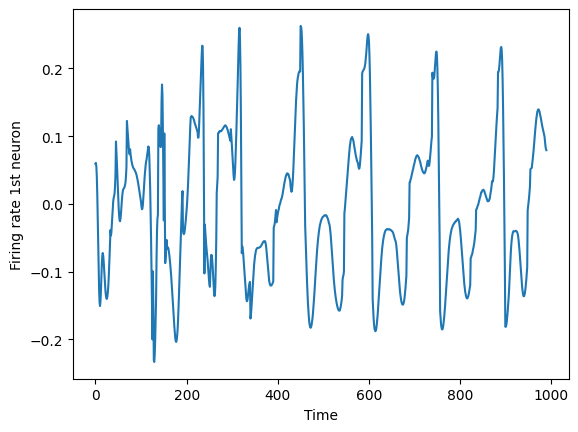

In [51]:
plt.plot(data['Pseudo-Predictions']['Matrix'][10000 :1000,0:5,0].sum(axis=1))
plt.xlabel('Time')
plt.ylabel('Firing rate 1st neuron')

Text(0, 0.5, 'Firing rate 1st neuron')

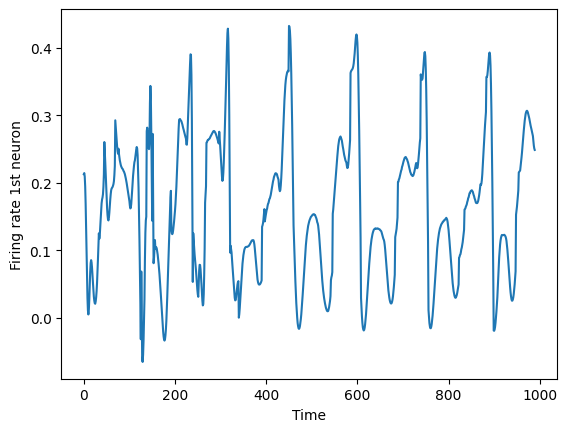

In [52]:
plt.plot(data['Pseudo-Predictions']['Matrix'][10:1000,0:6,0].sum(axis=1))
plt.xlabel('Time')
plt.ylabel('Firing rate 1st neuron')

Firing rate of locomotion is the sum of 1st 5 firing rates (linear and nonlinear). So sum them up. Then Z-score! sRRR from neuronal space to latent (2 dim / 3 dim who knows --- cross validate) to 4 behavioural variables, the x-positions of each limb.

In [48]:
data['Pseudo-Predictions']['Cell Names'][:10]

array([b'MC3808_S1', b'MC3808_S2', b'MC3808_S3', b'MC3808_S4',
       b'MC3808_S5', b'MC3808_S6', b'MC3808_S7', b'MC3810_S10',
       b'MC3810_S11', b'MC3810_S12'], dtype='|S10')

In [13]:
data['Locomotion Reference'].keys()

dict_keys(['4D-phase Trig. Decomp.', 'Acq. Freq.', 'Cross-validated Pseudo-dominance outputs', 'Global Phase 4D distance', 'Global Phase PCA embeddings', 'Original Sessions of Behavioral Reference', 'PCA selected embeddings and rotation sense', 'PCA-phase Trig. Decomp.', 'Phaser-phase Trig. Decomp.', 'Phases', 'Wheel Speed', 'X-accel Matrix', 'X-pos Matrix', 'X-speed Matrix', 'Y-accel Matrix', 'Y-pos Matrix', 'Y-speed Matrix', 'Z-accel Matrix', 'Z-pos Matrix', 'Z-speed Matrix'])

In [41]:
select_cells=data['Locomotion Reference']['Cross-validated Pseudo-dominance outputs']['Locomotion_signif'].astype(bool)

In [44]:
select_cells.shape

(103,)

In [46]:
data['Pseudo-Predictions']['Matrix'][:,:4,:].shape

(1816281, 4, 105)

In [48]:
# sum linear and nonlinear components of firing rates without nuisance
X = data['Pseudo-Predictions']['Matrix'][:,:4,:].sum(axis=1)
#X = X[:,select_cells]
#Y = data['Locomotion Reference']['Pos. X Matrix'],
limbs=['FR','HR','FL','HL']
selected_features =  list(data['Locomotion Reference'].keys())[-10:]
#locomotion_names=limbs

Y = []
locomotion_names=[]
for feature in selected_features:
    if feature == 'Wheel Speed':
        Y.append(data['Locomotion Reference'][feature][:,np.newaxis])
        locomotion_names.append(feature)
    else:
        Y.append(data['Locomotion Reference'][feature])
        for limb in limbs:
            locomotion_names.append(feature[:3]+' '+limb)
Y = np.concatenate(Y, axis=1)
#Y = Y[select_cells,:]


cell_names = data['Pseudo-Predictions']['Cell Names']
purkinjedata = {'Firing rate':X, 'Locomotion':Y, 'cell_names':cell_names, 'locomotion_names':locomotion_names, 'sampling rate (Hz)': 330}

#pickle.dump(purkinjedata, open('../data/purkinje.pickle', 'wb'))
pickle.dump(purkinjedata, open('../data/purkinje_extended_linear.pickle', 'wb'))

# double check
print('Number of time points: ', X.shape[0])
print('Number of neurons: ', X.shape[1])
print('Number of locomotion features: ', Y.shape[1])
print('X and Y shapes: ', X.shape, Y.shape)
print('Neuron names: ', cell_names[:10], ' ...')
print('Locomotion features: ', locomotion_names)

Number of time points:  1816281
Number of neurons:  105
Number of locomotion features:  37
X and Y shapes:  (1816281, 105) (1816281, 37)
Neuron names:  [b'MC3808_S1' b'MC3808_S2' b'MC3808_S3' b'MC3808_S4' b'MC3808_S5'
 b'MC3808_S6' b'MC3808_S7' b'MC3810_S10' b'MC3810_S11' b'MC3810_S12']  ...
Locomotion features:  ['Wheel Speed', 'X-a FR', 'X-a HR', 'X-a FL', 'X-a HL', 'X-p FR', 'X-p HR', 'X-p FL', 'X-p HL', 'X-s FR', 'X-s HR', 'X-s FL', 'X-s HL', 'Y-a FR', 'Y-a HR', 'Y-a FL', 'Y-a HL', 'Y-p FR', 'Y-p HR', 'Y-p FL', 'Y-p HL', 'Y-s FR', 'Y-s HR', 'Y-s FL', 'Y-s HL', 'Z-a FR', 'Z-a HR', 'Z-a FL', 'Z-a HL', 'Z-p FR', 'Z-p HR', 'Z-p FL', 'Z-p HL', 'Z-s FR', 'Z-s HR', 'Z-s FL', 'Z-s HL']
